In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import scipy as sp
import imageio.v3 as imageio
import skimage as ski
from tqdm.auto import trange
import texture_segmentation.gabor as gabor
import texture_segmentation.diffusion as diffusion
import texture_segmentation.segment as segment

plt.rcParams['image.cmap'] = 'gray'

In [2]:
def approximate_delta(x: NDArray, epsilon: float = 1e-6):
    divisor = np.abs(epsilon) * np.sqrt(np.pi)
    return np.exp(-x**2 / epsilon**2) / divisor

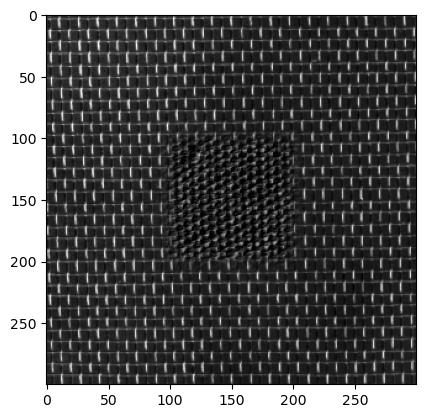

In [3]:
imsize = 300
# backgroud_texture_id = 5
# inner_texture_id = 80
backgroud_texture_id = 6
inner_texture_id = 77

bg_image_url = f"https://www.ux.uis.no/~tranden/brodatz/D{backgroud_texture_id}.gif"
texture_image_url = f"https://www.ux.uis.no/~tranden/brodatz/D{inner_texture_id}.gif"


bg_image = imageio.imread(bg_image_url)
bg_image = bg_image[:, 0:imsize, 0:imsize].astype(float) / 255

texture_image = imageio.imread(texture_image_url)
texture_image = texture_image[:, 0:imsize, 0:imsize].astype(float) / 255
mask = np.zeros_like(bg_image)
# mask[:, imsize//3:-imsize//3, imsize//3:-imsize//3] = 1
mask[:, imsize//3:-imsize//3, imsize//3:-imsize//3] = 1
mask = sp.ndimage.gaussian_filter(mask, sigma=(0, 5, 5))

texture_image = texture_image - texture_image.mean() + bg_image.mean()
texture_image = texture_image * bg_image.std() / texture_image.std()
texture_image = np.clip(texture_image, 0, 1)

image = (1 - mask) * bg_image + mask * texture_image
image -= image.min()
image /= image.max()
# image = np.random.normal(image, 0.1)
image = np.clip(image, 0, 1)
image = image[0]
plt.imshow(image)
plt.show()

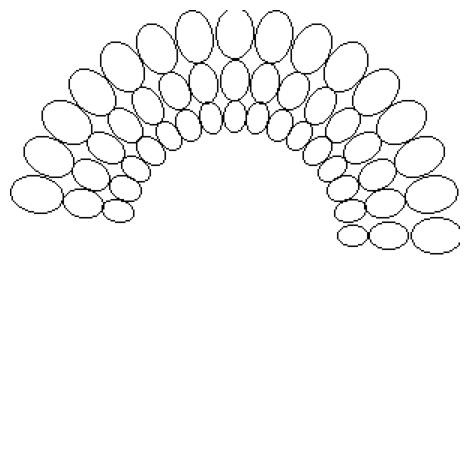

In [4]:
filter_bank_params = {
    'num_angles': 16,
    'full_circle': False,
    'scaling_factor': 0.6,
    'num_scales': 3,
    'sigma_x0': 0.10,
    "sigma_y0": 0.07
}

arr = gabor.plot_gabor_filter_bank_fft_fwhm(300, **filter_bank_params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.imshow(arr, cmap="binary")
ax.set_axis_off()
plt.tight_layout()
plt.show()

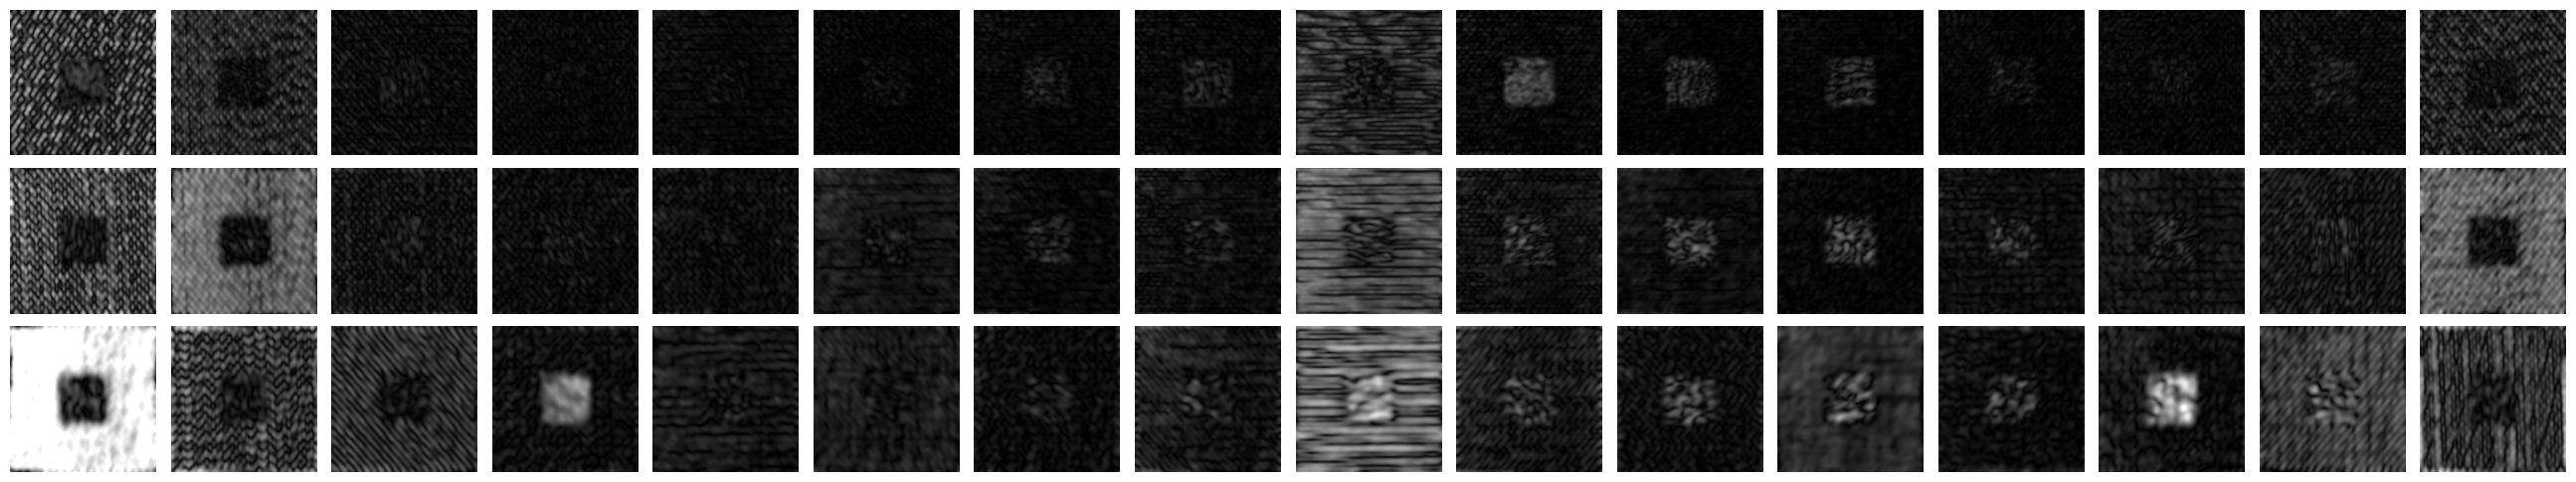

In [5]:
gabor_features_complex = gabor.gabor_features_raw(image, filter_bank_params)

# im = np.zeros((*gabor_features_complex.shape, 3), dtype=float)
# im[..., 0] = gabor_features_complex.real
# im[..., 2] = gabor_features_complex.imag

im = np.abs(gabor_features_complex)
vmin = np.quantile(im, 0.01)
vmax = np.quantile(im, 0.99)
# vmin = im.min()
# vmax = im.max()
im = im - vmin
im = im / vmax


# Plot the complex gabor features
s = 5
fig, axs = plt.subplots(nrows=im.shape[0], ncols=im.shape[1], figsize=(int(s * im.shape[1] / im.shape[0]), s))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        axs[i, j].imshow(im[i, j], vmin=0, vmax=1)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 38.96it/s]


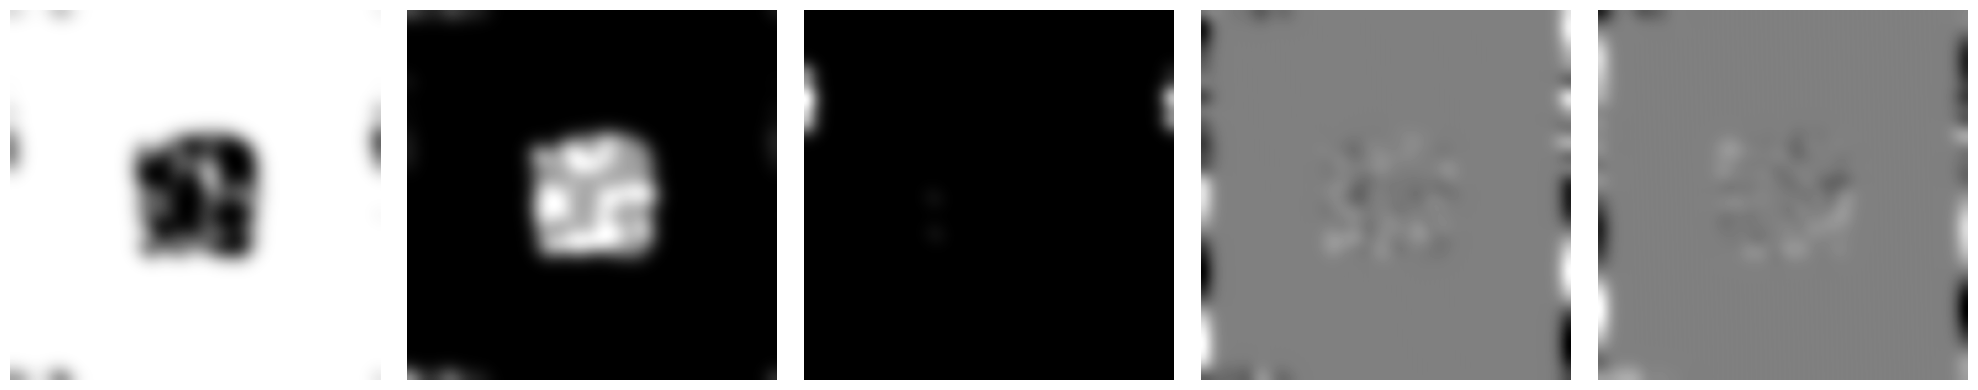

In [6]:
features, hl_features, names = gabor.gabor_features(image, filter_bank_params)
hl_features -= hl_features.mean(axis=(-2, -1), keepdims=True)
hl_features /= (hl_features.std(axis=(-2, -1), keepdims=True) + 1e-6)
hl_features_post = gabor.features_post_process(hl_features, sigma=7, diffusion_eta=0.1, diffusion_steps=20)
# hl_features_post = sp.ndimage.gaussian_filter(hl_features_post, sigma=(0, 5, 5))
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(hl_features_post[i])
    axs[i].axis("off")
plt.tight_layout()

plt.show()

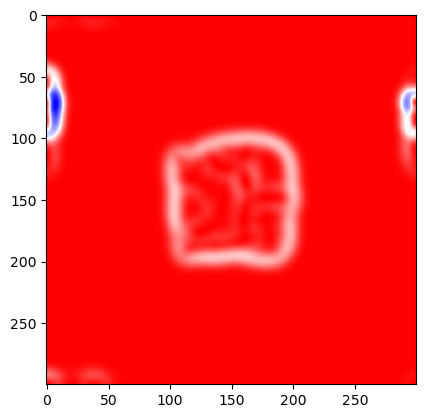

0.5171846726619727 0.9999999499390039


In [7]:
g = segment.isotropic_metric(hl_features_post)
E = np.sqrt(g)
plt.imshow(E, cmap="bwr")
plt.show()

print(E.min(), E.max())

(300, 300)


  0%|          | 0/5 [00:00<?, ?it/s]

0.0022; 0.0033: 100%|██████████| 5/5 [00:00<00:00, 269.86it/s]


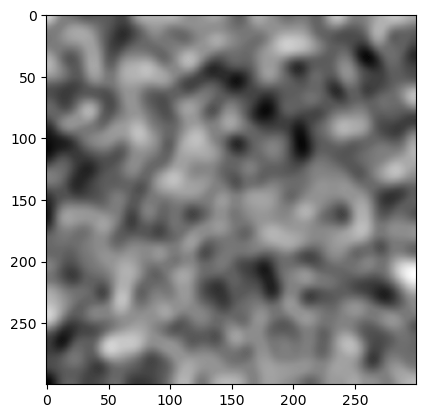

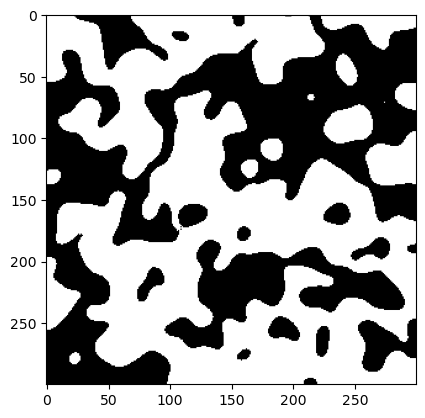

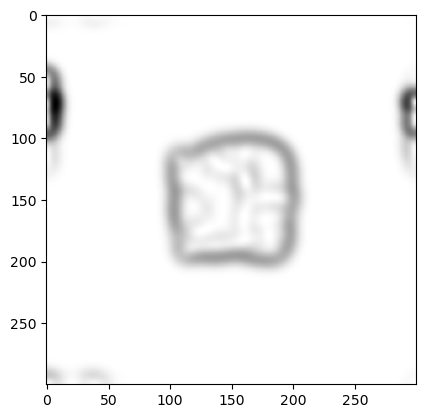

In [8]:
# phi0 = ski.segmentation.checkerboard_level_set((300, 300), 50).astype(float) - 0.5
# phi0 *= 0.1
# phi0 += np.random.randn(*phi0.shape) * 0.1

phi0 = np.random.randn(*hl_features_post.shape[-2:]) * 0.2
phi0 = sp.ndimage.gaussian_filter(phi0, sigma=7)
res = segment.deodesic_active_contours_segment(hl_features_post, phi0, it=5, eta=1, c=0.1)
plt.imshow(res["phi"])
plt.show()
plt.imshow((res["phi"] >= 0).astype(float))
plt.show()
plt.imshow(res["E"])
plt.show()

100%|██████████| 100/100 [00:00<00:00, 125.82it/s]


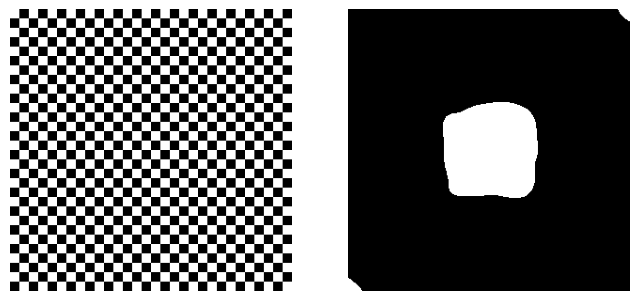

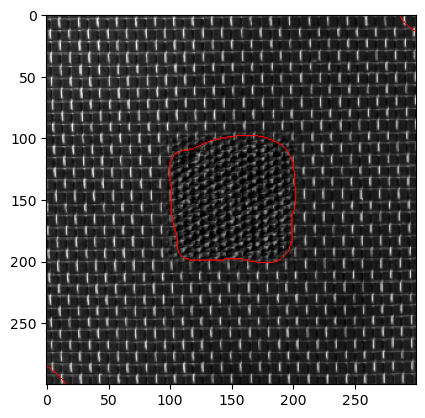

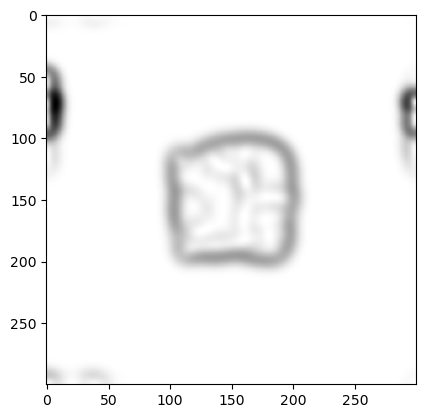

In [18]:
phi0 = 2 * ski.segmentation.checkerboard_level_set((300, 300), 10).astype(float) - 1
# phi0 = 2 * ski.segmentation.disk_level_set(image_shape=(300, 300)).astype(float) - 1
phi0 = sp.ndimage.gaussian_filter(phi0, sigma=5)
res = segment.vector_chan_vase(hl_features_post, phi0, eta=1, it=100, lambda_c=0.5, mu=0.3, combined_mathod=True)


segmented_region = 2 * (res["phi"] <= 0).astype(float) - 1
segmented_region = sp.ndimage.gaussian_filter(segmented_region, sigma=2) <=0

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].imshow(phi0 <= 0)
axs[1].imshow(segmented_region)
axs[0].axis("off")
axs[1].axis("off")
plt.show()

# phi_f = ski.segmentation.clear_border(phi_f, buffer_size=2)
bound = ski.segmentation.mark_boundaries(image, segmented_region, color=(1, 0, 0)).astype(float)
plt.imshow(bound)
plt.show()

plt.imshow(res["h"])
plt.show()

In [10]:
res["h"].min(), res["h"].max()

(0.5171846726619724, 0.9999999499390039)

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


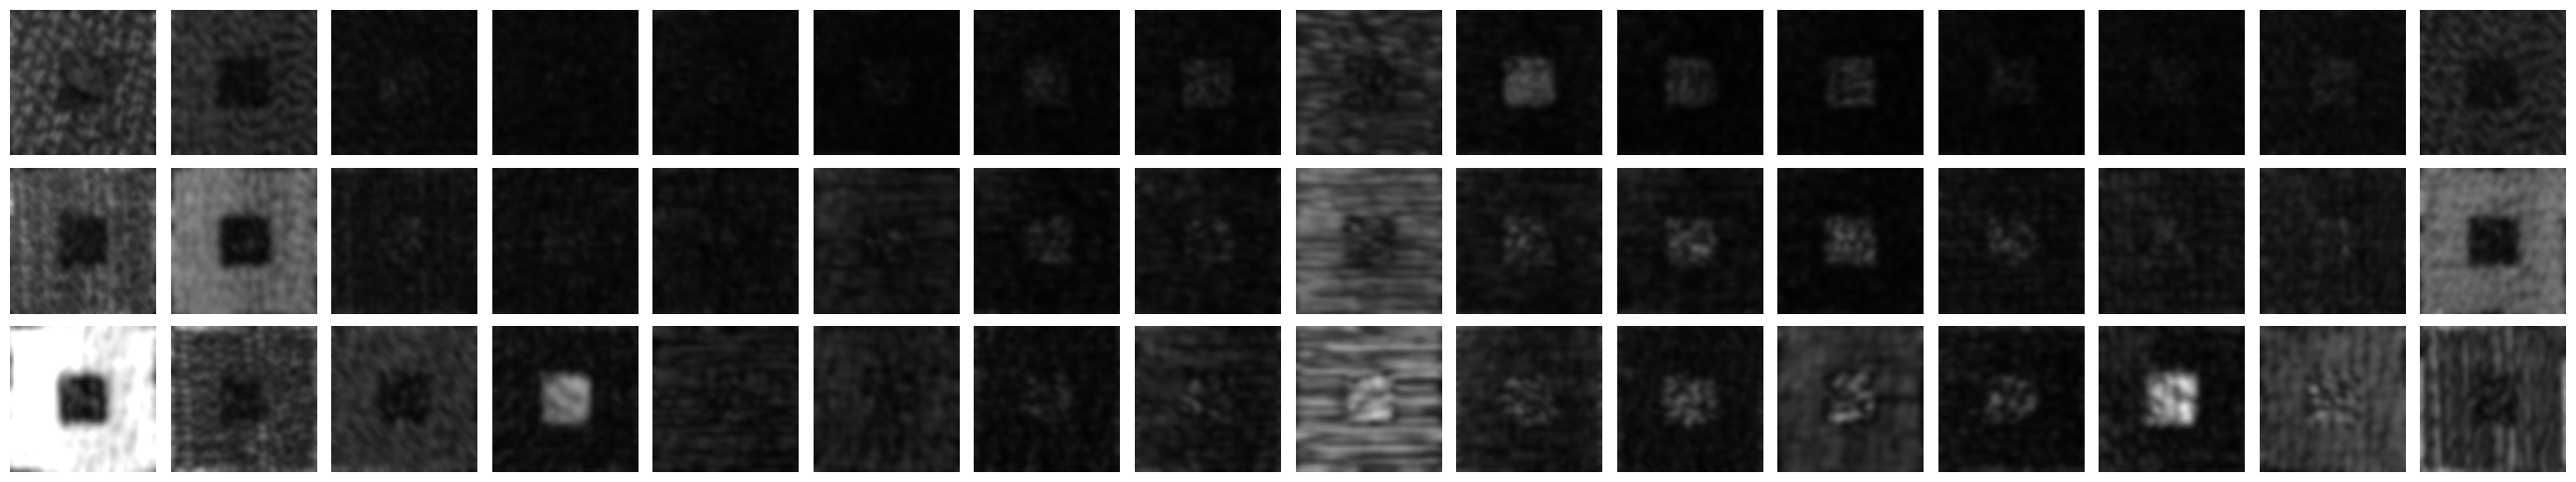

In [11]:
m, k, h, w = gabor_features_complex.shape
X = np.abs(gabor_features_complex).reshape(-1, *gabor_features_complex.shape[-2:])
means = X.mean(axis=0, keepdims=True)
stds = X.std(axis=0, keepdims=True)
# X = (X - means) / stds
X = sp.ndimage.gaussian_filter(X, sigma=(0, 5, 5))
X = diffusion.diffuse_features(X, it=10, eta=0.1)
# X = X * stds + means

im_d = np.abs(X).reshape(m, k, h, w)

# im_d = im_d
# vmin = im_d.min()
# vmax = im_d.max()

im_d = im_d - vmin
im_d = im_d / vmax
im_d = np.clip(im_d, 0, 1)


# Plot the complex gabor features
s = 5
fig, axs = plt.subplots(nrows=im_d.shape[0], ncols=im_d.shape[1], figsize=(int(s * im_d.shape[1] / im_d.shape[0]), s))
for i in range(im_d.shape[0]):
    for j in range(im_d.shape[1]):
        axs[i, j].imshow(im_d[i, j], vmin=0, vmax=1)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

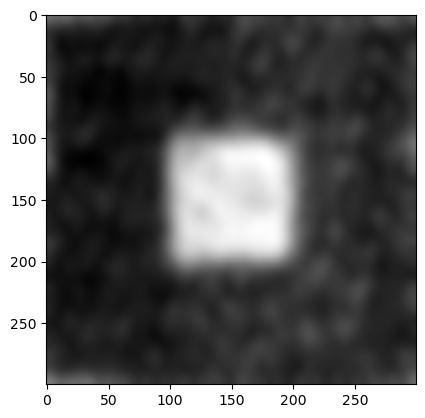

In [12]:
from sklearn.decomposition import PCA
import math

pixels = X.reshape(X.shape[0], -1).T
pca = PCA(n_components=10)
pca.fit(pixels)

pixels_pca = pca.transform(pixels).T
pixels_pca = pixels_pca.reshape(10, h, w)
plt.imshow(pixels_pca[0])
plt.show()


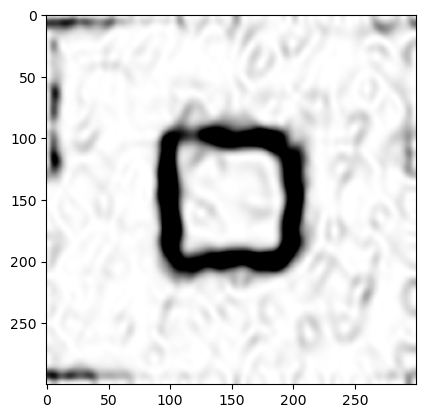

In [13]:


grad = np.gradient(pixels_pca[0])
grad = np.sqrt(grad[0]**2 + grad[1]**2)
im = 1 / (1 + grad ** 2)

vmin = np.quantile(im, 0.05)
vmax = np.quantile(im, 0.95)
plt.imshow(im , vmin=vmin, vmax=vmax)
plt.show()

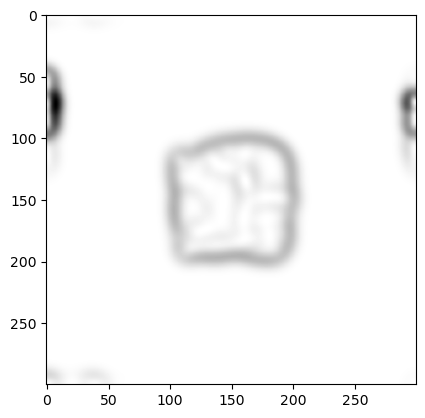

In [14]:
X = hl_features_post

g = diffusion.metric(X)
plt.imshow(1 / np.linalg.det(g))